In [3]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read and combine data from CSV files in the "data" folder
data_folder = 'data'
csv_files = glob.glob(os.path.join(data_folder, '*.csv'))

dataframes = []
for file in csv_files:
    # Read each CSV and parse the 'timestamp' column as datetime
    df = pd.read_csv(file, parse_dates=['timestamp'])
    dataframes.append(df)
    
# Combine all the data into a single DataFrame
df_all = pd.concat(dataframes, ignore_index=True)
df_all.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52200 entries, 0 to 52199
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   timestamp      52200 non-null  datetime64[ns]
 1   state          52200 non-null  object        
 2   power          52200 non-null  float64       
 3   auto_shutdown  52200 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), object(1)
memory usage: 1.2+ MB


In [4]:
print(df_all.head())

            timestamp    state    power  auto_shutdown
0 2025-01-01 08:00:00  running  1044.39          False
1 2025-01-01 08:00:05  running  1078.02          False
2 2025-01-01 08:00:10  running  1082.94          False
3 2025-01-01 08:00:15  running  1299.40          False
4 2025-01-01 08:00:20  running  1103.12          False


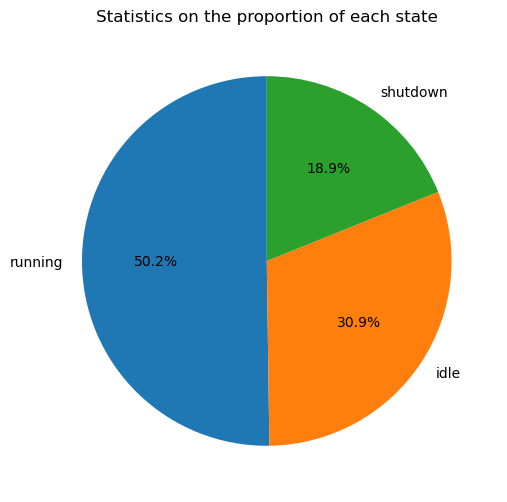

In [5]:
# Make a copy of the original data
df_modified = df_all.copy()

# Set power to 0 where auto_shutdown is True to simulate power cut-off
df_modified.loc[df_modified['auto_shutdown'] == True, 'power'] = 0

# Count the number of occurrences of each state
state_counts = df_all['state'].value_counts()

# Plot a pie chart showing the proportion of each state
plt.figure(figsize=(6,6))
plt.pie(state_counts, labels=state_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Statistics on the proportion of each state")
plt.show()


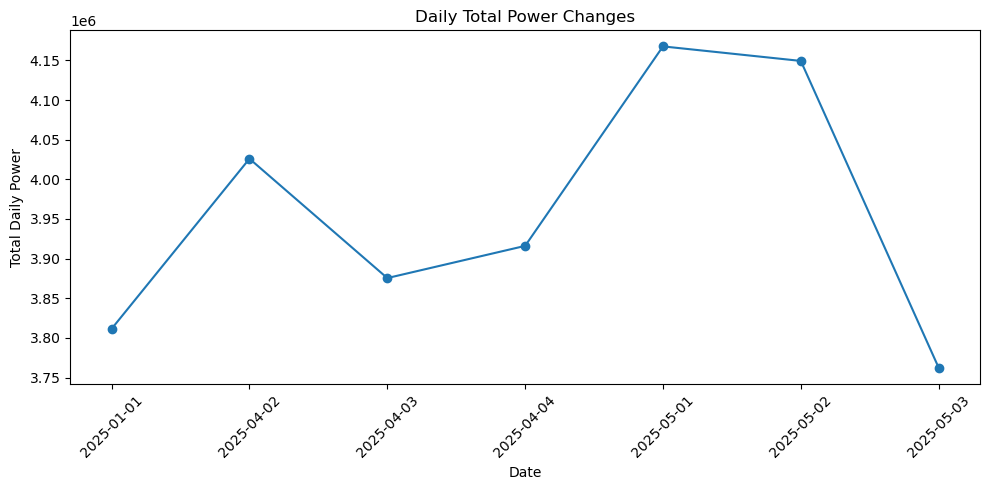

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract date from timestamp (as string in YYYY-MM-DD format)
df_all['date_str'] = df_all['timestamp'].dt.strftime('%Y-%m-%d')

# Group by date and calculate total power for each day
daily_power = df_all.groupby('date_str')['power'].sum().reset_index()

# Map each unique date to a sequential x-axis index for even spacing
unique_days = sorted(daily_power['date_str'].unique())
day_to_index = {day: i for i, day in enumerate(unique_days)}
daily_power['x_val'] = daily_power['date_str'].map(day_to_index)

# Plot total power for each day using mapped x values
plt.figure(figsize=(10, 5))
plt.plot(daily_power['x_val'], daily_power['power'], marker='o', linestyle='-')
plt.xlabel("Date")
plt.ylabel("Total Daily Power")
plt.title("Daily Total Power Changes")

# Set x-axis ticks to show actual date labels
plt.xticks(
    ticks=range(len(unique_days)),
    labels=unique_days,
    rotation=45
)

plt.tight_layout()
plt.show()


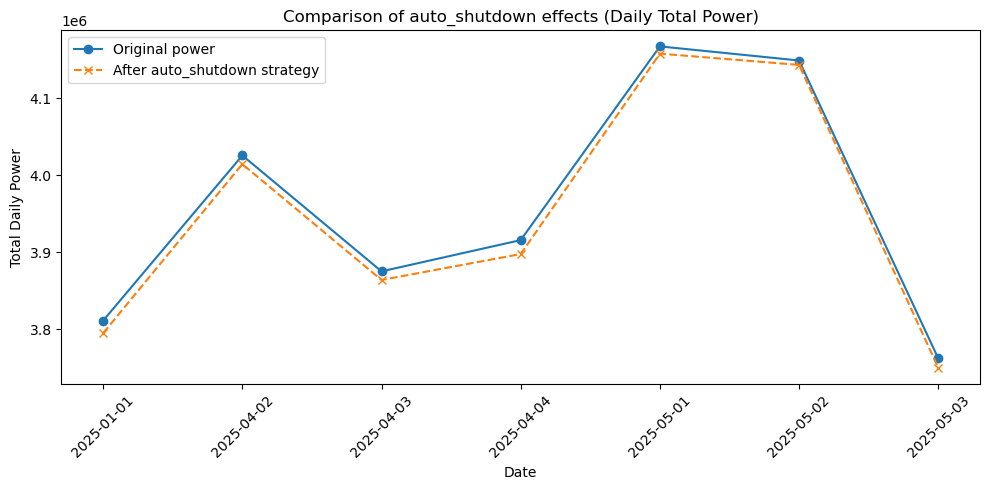

In [7]:
import pandas as pd
import matplotlib.pyplot as plt


df_all['timestamp'] = pd.to_datetime(df_all['timestamp'])
df_modified['timestamp'] = pd.to_datetime(df_modified['timestamp'])
df_all.sort_values('timestamp', inplace=True)
df_modified.sort_values('timestamp', inplace=True)

# Extract the date (YYYY-MM-DD) from each timestamp
df_all['date_str'] = df_all['timestamp'].dt.strftime('%Y-%m-%d')
df_modified['date_str'] = df_modified['timestamp'].dt.strftime('%Y-%m-%d')

# Group by date and sum up the power values for each day
daily_all = df_all.groupby('date_str', as_index=False)['power'].sum()
daily_modified = df_modified.groupby('date_str', as_index=False)['power'].sum()

# Create a mapping from each date to a sequential index for evenly spaced x-axis
unique_days = sorted(daily_all['date_str'].unique())
day_to_index = {day: i for i, day in enumerate(unique_days)}

# Map the date strings to discrete x values
daily_all['x_val'] = daily_all['date_str'].map(day_to_index)
daily_modified['x_val'] = daily_modified['date_str'].map(day_to_index)

# Plot total power per day before and after auto_shutdown strategy
plt.figure(figsize=(10,5))
plt.plot(daily_all['x_val'], daily_all['power'], label='Original power', marker='o', linestyle='-')
plt.plot(daily_modified['x_val'], daily_modified['power'], label='After auto_shutdown strategy', marker='x', linestyle='--')

plt.xlabel("Date")
plt.ylabel("Total Daily Power")
plt.title("Comparison of auto_shutdown effects (Daily Total Power)")
plt.legend()

# Set custom x-axis ticks using actual date strings
plt.xticks(
    ticks=range(len(unique_days)),
    labels=unique_days,
    rotation=45
)

plt.tight_layout()
plt.show()


In [8]:
# Sort the full dataset by timestamp to ensure correct time order行
df_all.sort_values('timestamp', inplace=True)

# Filter out records where the state is 'idle'
df_idle = df_all[df_all['state'] == 'idle'].copy()

idle_durations = []


if not df_idle.empty:
    # Calculate time difference between consecutive idle records (in seconds)
    df_idle['timedelta'] = df_idle['timestamp'].diff().dt.total_seconds()
    
    # Define a gap threshold (in seconds) to split idle sessions
    # For example, if data is sampled every 5 seconds, a gap over 10 seconds breaks the idle streak
    threshold = 10  
    duration = 0
    
    # Iterate over the time differences to accumulate idle durations
    for dt in df_idle['timedelta'].fillna(0):
        if dt < threshold:
            duration += dt
        else:
            # Save the accumulated idle time if the gap is too large
            if duration > 0:
                idle_durations.append(duration)
            duration = 0
    
    # Append the final segment if it wasn't added
    if duration > 0:
        idle_durations.append(duration)


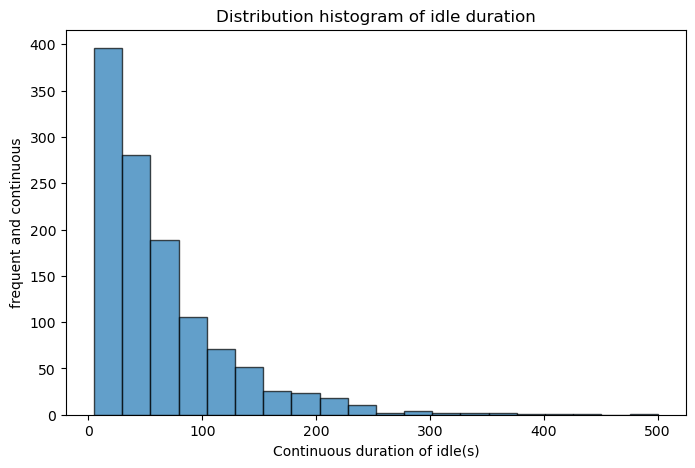

In [9]:
plt.figure(figsize=(8,5))
plt.hist(idle_durations, bins=20, alpha=0.7, edgecolor='black')
plt.xlabel("Continuous duration of idle(s)")
plt.ylabel("frequent and continuous")
plt.title("Distribution histogram of idle duration")
plt.show()
    

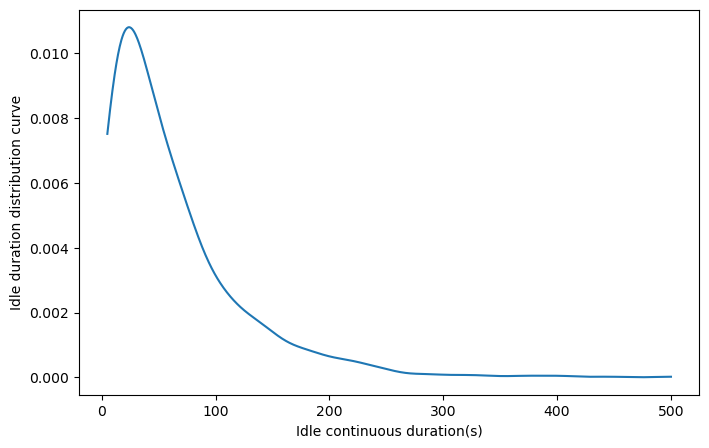

In [10]:
from scipy.stats import gaussian_kde

density = gaussian_kde(idle_durations)
xs = np.linspace(min(idle_durations), max(idle_durations), 1000)
plt.figure(figsize=(8,5))
plt.plot(xs, density(xs))
plt.xlabel("Idle continuous duration(s)")
plt.ylabel("Idle duration distribution curve")
plt.title("")
plt.show()


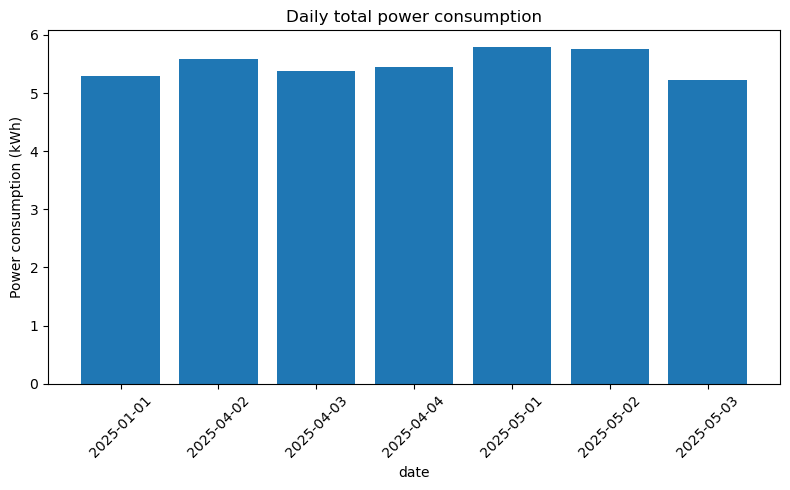

In [11]:
df_all['date'] = df_all['timestamp'].dt.date
time_interval = 5
df_energy = df_all.groupby('date')['power'].sum().reset_index()
df_energy['energy_kwh'] = df_energy['power'] * time_interval / 3600000

plt.figure(figsize=(8,5))
plt.bar(df_energy['date'].astype(str), df_energy['energy_kwh'])
plt.xlabel("date")
plt.ylabel("Power consumption (kWh)")
plt.title("Daily total power consumption")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()